# LSTM Neural Net Model

### Imports

In [39]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', None)

In [2]:
daily = pd.read_csv('./datasets/london_smart_meters/ds_master.csv')
daily['day'] = pd.to_datetime(daily['Unnamed: 0'])
daily.set_index('day', inplace=True)
daily.drop(columns='Unnamed: 0', inplace=True)
daily.head()

,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,temperatureMax,temperatureLow,windSpeed,cloudCover,humidity,visibility,holiday
day,,,,,,,,,,,,,,
2011-11-23,2.9660,3.654184,9.835,334,2.264165,90.385000,1.113,10.36,8.24,2.04,0.36,0.93,8.06,0
2011-11-24,4.8395,5.855170,19.046,922,3.909215,213.412000,2.019,12.93,9.71,4.04,0.41,0.89,10.64,0
2011-11-25,5.6890,7.196841,23.246,1383,4.962879,303.993000,2.283,13.03,7.01,5.02,0.48,0.79,12.38,0
2011-11-26,8.3345,10.153053,33.868,1773,7.115718,420.976000,3.002,12.96,11.59,5.75,0.44,0.81,13.07,0
2011-11-27,7.4235,9.268396,35.484,1968,7.180928,444.883001,2.867,13.54,1.31,5.48,0.42,0.72,13.08,0


Adjust the order of the columns so that they fit in the series to supervised function

In [3]:
daily = daily.loc[daily.index[290:-1], ['energy_sum',
                                         'energy_mean',
                                         'energy_max',
                                         'energy_count',
                                         'energy_std',
                                         'energy_median',
                                         'energy_min',
                                         'temperatureMax',
                                         'temperatureLow',
                                         'windSpeed',
                                         'cloudCover',
                                         'humidity',
                                         'visibility',
                                         'holiday']]
                                     

### Plot Temperature next to energy load

Text(0, 0.5, 'Total Electricity Consumed (kWh)')

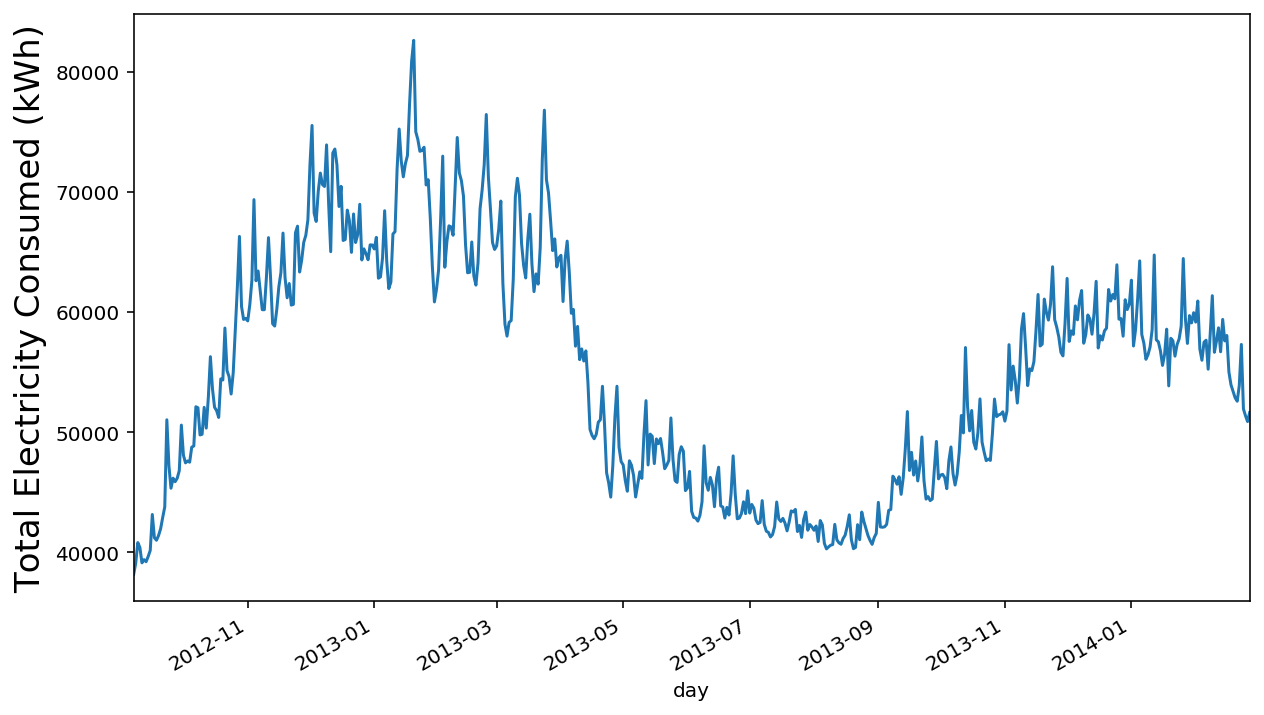

In [4]:
plt.figure(figsize=(10, 6))
daily['energy_sum'].plot()
plt.ylabel('Total Electricity Consumed (kWh)', fontsize = 17)
#plt.xlabel('day', fontsize=20)

Text(0, 0.5, 'temperature (celcius)')

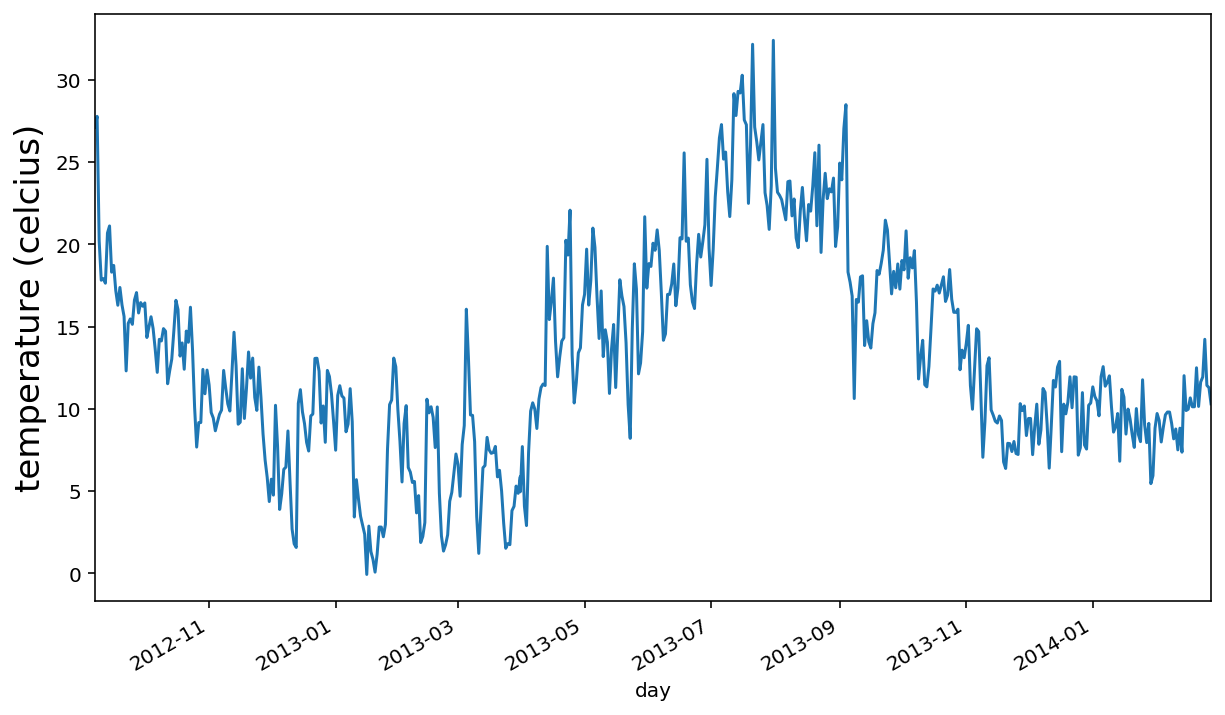

In [5]:
plt.figure(figsize=(10, 6))
daily['temperatureMax'].plot()
plt.ylabel('temperature (celcius)', fontsize=17)
#plt.xlabel(', fontsize=20)

In [6]:
daily.corr()[['energy_sum', 'energy_mean']].sort_values(by='energy_sum')

,energy_sum,energy_mean
temperatureMax,-0.875222,-0.876493
temperatureLow,-0.785074,-0.787380
visibility,-0.291420,-0.292440
holiday,0.051727,0.050994
windSpeed,0.147877,0.145768
cloudCover,0.302118,0.300059
humidity,0.400611,0.401973
energy_count,0.462204,0.454812
energy_min,0.901384,0.905306
energy_max,0.979661,0.979273


## LSTM Model

Create function that converts time series data into a shifted series that can be input into a neural network pipeline

citing work from: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
data = series_to_supervised(daily, 1, 1)

In [9]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [10]:
values = daily.values
# ensure all data is float
values = values.astype(float)
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [11]:
# drop columns that you dont want to predict
reframed.drop(reframed.columns[[15,16,17,18,19,20,21,22,23,24,25,26,27]], axis=1, inplace=True)

### Train test split

In [12]:
daily.shape

(542, 14)

In [13]:
543*.1

54.300000000000004

In [14]:
543-54

489

In [15]:
# split into train and test sets
values = reframed.values
n_train_hours = 489
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(489, 1, 14) (489,) (52, 1, 14) (52,)


### Set up Neural Network

In [16]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 489 samples, validate on 52 samples
Epoch 1/50
489/489 - 1s - loss: 0.3096 - val_loss: 0.2770
Epoch 2/50
489/489 - 0s - loss: 0.2131 - val_loss: 0.1590
Epoch 3/50
489/489 - 0s - loss: 0.1661 - val_loss: 0.0787
Epoch 4/50
489/489 - 0s - loss: 0.1415 - val_loss: 0.0471
Epoch 5/50
489/489 - 0s - loss: 0.1259 - val_loss: 0.0461
Epoch 6/50
489/489 - 0s - loss: 0.1130 - val_loss: 0.0457
Epoch 7/50
489/489 - 0s - loss: 0.0989 - val_loss: 0.0429
Epoch 8/50
489/489 - 0s - loss: 0.0852 - val_loss: 0.0421
Epoch 9/50
489/489 - 0s - loss: 0.0730 - val_loss: 0.0429
Epoch 10/50
489/489 - 0s - loss: 0.0612 - val_loss: 0.0432
Epoch 11/50
489/489 - 0s - loss: 0.0511 - val_loss: 0.0435
Epoch 12/50
489/489 - 0s - loss: 0.0445 - val_loss: 0.0435
Epoch 13/50
489/489 - 0s - loss: 0.0411 - val_loss: 0.0432
Epoch 14/50
489/489 - 0s - loss: 0.0402 - val_loss: 0.0425
Epoch 15/50
489/489 - 0s - loss: 0.0403 - val_loss: 0.0423
Epoch 16/50
489/489 - 0s - loss: 0.0400 - val_loss: 0.0421
Epoch 17/50
489/489 

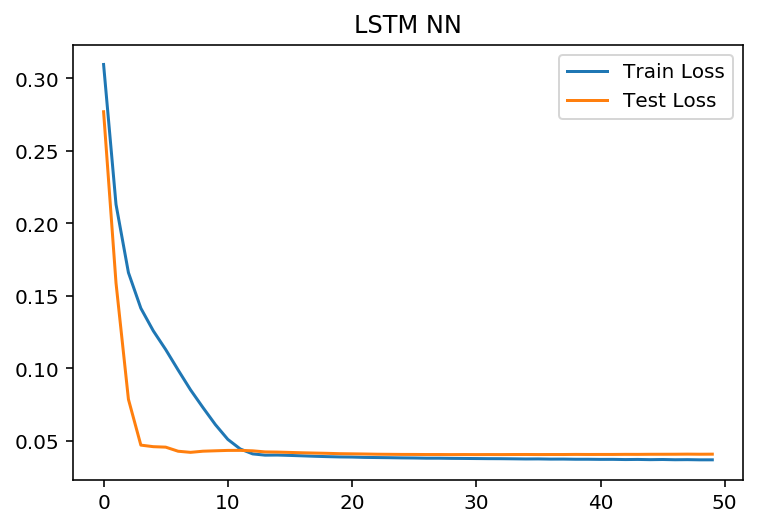

In [17]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('LSTM NN')
plt.legend();

### Make predictions

In [18]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [19]:
# invert scaling for forecast
inv_yhat = pd.concat((pd.DataFrame(yhat), pd.DataFrame(test_X[:, 1:])), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = pd.concat((pd.DataFrame(test_y), pd.DataFrame(test_X[:, 1:])), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2347.127


#### Test RMSE: 
# 2,347 kWh

### Plot Predictions

first invert the scaling of y_train

In [20]:
train_X.shape

(489, 1, 14)

In [21]:
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
inv_train_y = pd.concat((pd.DataFrame(train_y), pd.DataFrame(train_X[:, 1:])), axis=1)
inv_train_y = scaler.inverse_transform(inv_train_y)
inv_train_y = inv_train_y[:, 0]

In [22]:
y_train = pd.DataFrame(inv_train_y)
y_test = pd.DataFrame(inv_y)
y_preds = pd.DataFrame(inv_yhat)

In [23]:
y_true = pd.concat((y_train, y_test), axis=0)
y_true['date'] = daily.index[1::]
y_true['energy_sum'] = y_true[0]
y_true.drop(columns=0, inplace=True)
y_true.set_index('date', inplace=True)

In [24]:
y_preds['date'] = daily.index[490::]
y_preds['energy_sum'] = y_preds[0]
y_preds.drop(columns=0, inplace=True)
y_preds.set_index('date', inplace=True)

In [25]:
5/8

0.625

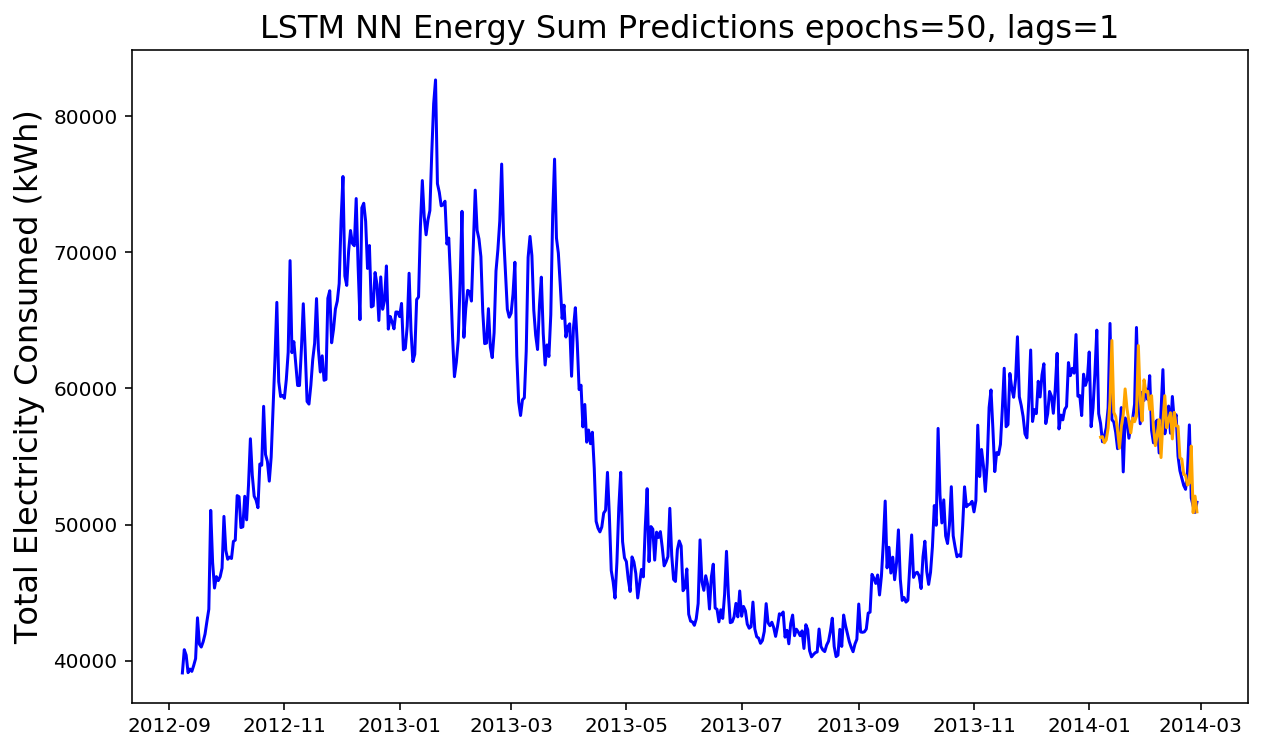

In [26]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_true.index, y_true['energy_sum'], color = 'blue')

# Plot predicted test data.
plt.plot(y_preds.index, y_preds['energy_sum'], color = 'orange')

plt.title(label = 'LSTM NN Energy Sum Predictions epochs=50, lags=1', fontsize=16)
plt.ylabel('Total Electricity Consumed (kWh)', fontsize=16)
plt.show();

## LSTM using time series generator

In [27]:
X = daily.loc[daily.index[290:-1],:].drop(columns='energy_sum')
y = daily.loc[daily.index[290:-1],'energy_sum'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# time series generator
train_seq = TimeseriesGenerator(X_train_sc, 
                                y_train, 
                                length = 3, 
                                batch_size = 32)

test_seq = TimeseriesGenerator(X_test_sc, 
                               y_test, 
                               length = 3, 
                               batch_size = 32)

In [28]:
from time import time

In [40]:
t0 = time()

# build model
model3 = Sequential()

model3.add(LSTM(50, input_shape=(3, 13)))

model3.add(Dense(6, activation='relu'))

model3.add(Dense(1, activation='linear'))

model3.compile(loss='mae', 
               optimizer='Adam')

# early stopping
es = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0
)

# fit model
hist = model3.fit_generator(train_seq,
                           epochs = 5000,
                           validation_data=test_seq,
                           verbose=0, 
                           callbacks=[es])

print(f'This took {round(((time() - t0)/60), 2)} minutes')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
This took 2.16 minutes


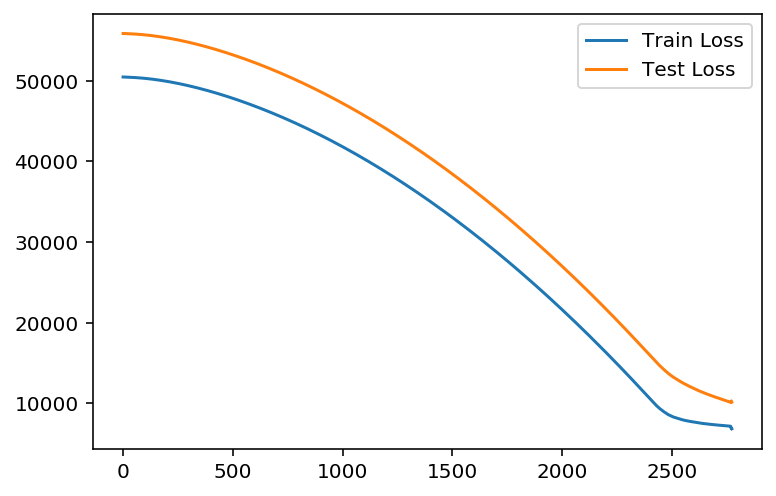

In [41]:
plt.plot(hist.history['loss'], label = 'Train Loss')
plt.plot(hist.history['val_loss'], label = 'Test Loss')
plt.legend();

In [83]:
y_hat = []
for i in model3.predict(test_seq):
    y_hat.append(float(i))

In [84]:
y_real = list(test_seq.targets)[3::]

In [85]:
len(y_hat), len(y_real)

(23, 23)

In [86]:
print(f'RMSE: {np.sqrt(mean_squared_error(y_real, y_hat)).round(2)} (kWh)')

RMSE: 10490.74 (kWh)


### Plot TimeseriesGenerator Predictions

In [93]:
len(daily.index[519::])

23

In [96]:
y_preds = pd.DataFrame(y_hat, columns=['energy_sum'])
y_preds['date'] = daily.index[519::]
y_preds.set_index('date', inplace=True)

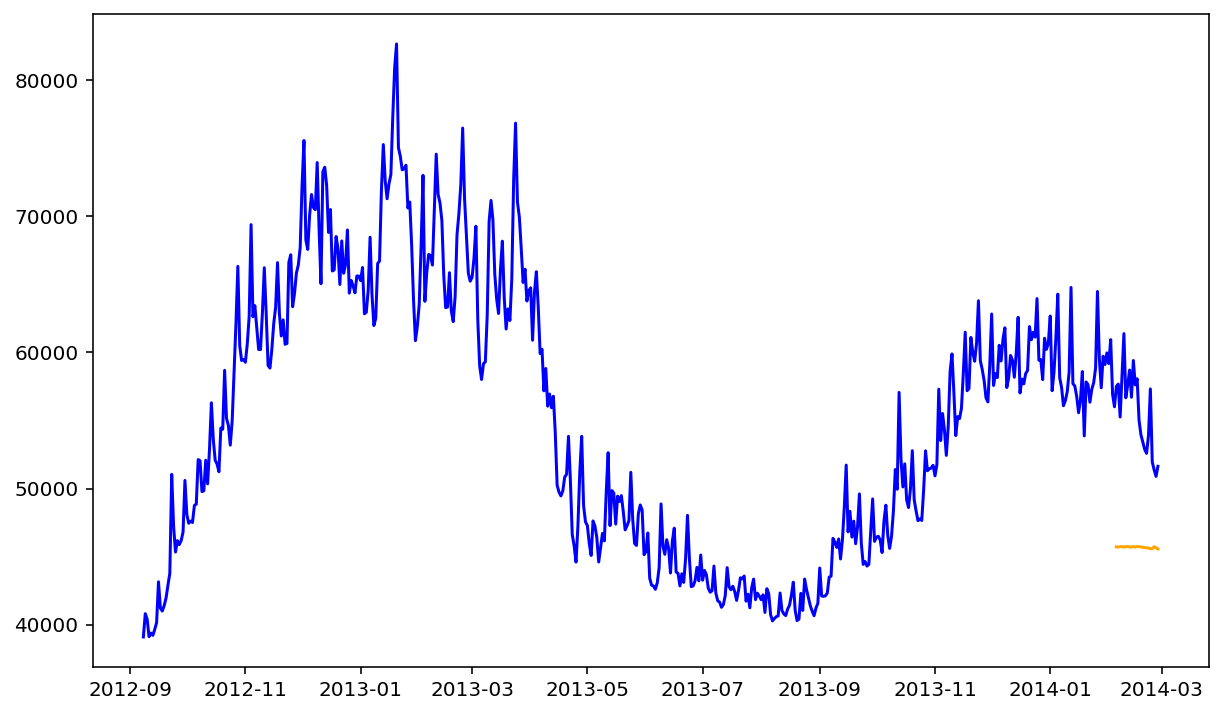

In [104]:
plt.figure(figsize=(10,6))

# Plot training data.
#plt.plot(daily.index[290:519], y_train, color = 'blue')
plt.plot(y_true.index, y_true['energy_sum'], color = 'blue')

# Plot testing data.
#plt.plot(daily.index[519::], pd.DataFrame(y_test)[0], color = 'orange')
plt.plot(y_preds.index, y_preds['energy_sum'], color='orange')

#plt.title(label = 'Once-Differenced daily mean energy consumption with ARIMA(3, 0, 3) Predictions', fontsize=16)
plt.show();